# Opening a Filipino resutaurant in Toronto


  ## Introduction & Data 

### First we will import and install all the packages & libraries needed

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors


%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

!conda install -c conda-forge wikipedia --yes 




print('Libraries imported.') 

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


## Next , We will import the tables from a Wikipedia page called 'Demographics of Toronto "

In [2]:
import pandas as pd
import numpy as np
import wikipedia as wp


html = wp.page("Demographics of Toronto").html().encode("UTF-8")

In [5]:
pip install lxml

     |████████████████████████████████| 5.5MB 6.0MB/s eta 0:00:01     |███████████████████████████▍    | 4.7MB 6.0MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


## Here , we will be using beautifulsoup package to extract Toronto data from the website and convert it to a dataframe

In [3]:
import pandas as pd

import requests

from bs4 import BeautifulSoup

#Using beautifulsoup package to extract Toronto data from the website and convert it to a dataframe

req = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")

soup = BeautifulSoup(req.content,'lxml')

table = soup.find_all('table')[0]

df = pd.read_html(str(table))

hood=pd.DataFrame(df[0])
hood.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


### Scrapping and cleaning the data

In [4]:
#renaming the coloumns 

hood.rename(columns = {"Postal Code" : " PostalCode"}, inplace = True )

hood.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [5]:
#removing the Not assigned Bouroughs 

hood= hood[hood.Borough != "Not assigned"].reset_index(drop=True)
hood.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [6]:
#grouping the data based on Borughs

hood = hood.groupby([" PostalCode", "Borough"], as_index=False).agg(lambda x: ", ".join(x))
hood.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [7]:
#Extracting the coordinates of the boroughs and renaming the colmuns 

coordinate=pd.read_csv("http://cocl.us/Geospatial_data")
coordinate.rename(columns = {"Postal Code" : " PostalCode"}, inplace = True)
coordinate.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [8]:
#merging the two tables above together

hood.set_index(" PostalCode")
coordinate.set_index(" PostalCode")
hood_merged=pd.merge(hood, coordinate)
hood_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [9]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(hood_merged['Borough'].unique()),
        hood_merged.shape[0]
    )
)

The dataframe has 10 boroughs and 103 neighborhoods.


In [10]:
#Getting the coordinates of Toronto

address = 'Toronto, CA'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [11]:
#Map of Toronto with its Borughs 

map_toronto = folium.Map(location = [latitude , longitude] , zoom_start =10)

for lat , lng , borough , neighborhood in zip ( hood_merged[ 'Latitude'],hood_merged['Longitude'], 
                                                               hood_merged['Borough'],hood_merged[ 'Neighborhood']):
    label = '{},{}'.format(neighborhood , borough)
    label = folium.Popup(label , parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        raduis=5,
         popup=label,
        color='blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.8 ,
        parse_html=False).add_to(map_toronto)
    
map_toronto 

## Connecting with Foursquare API , to extract the neighborhoods & venues

In [12]:
CLIENT_ID = 'E1X2E4K400WWQOT0R5M5RGVF2W2LMPZVID01544X4FINENQK' # your Foursquare ID
CLIENT_SECRET = 'M1JWH12XE1OHNNS3VJKM0KHAV0FCIESFYS53MNKUWONK11G2' # your Foursquare Secret
VERSION = '20200620' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: E1X2E4K400WWQOT0R5M5RGVF2W2LMPZVID01544X4FINENQK
CLIENT_SECRET:M1JWH12XE1OHNNS3VJKM0KHAV0FCIESFYS53MNKUWONK11G2


### Call the 'getNearbyVenues' function to obtain all the required data - , I expanded the radius to be 1700m and the venues limit to 900 to include as many restaurants as possible

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=1700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            900)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    print('Found {} venues in {} neighborhoods.'.format(nearby_venues.shape[0], len(venues_list)))
    
    return(nearby_venues)

### Getting the nearby neigborhoods of Toronto

In [15]:
Toronto_venues = getNearbyVenues(names=hood_merged["Neighborhood"],
                                   latitudes=hood_merged['Latitude'],
                                   longitudes=hood_merged['Longitude']
                                  )

Found 7741 venues in 103 neighborhoods.


In [16]:
print(Toronto_venues.shape)
Toronto_venues.head()

(7741, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Images Salon & Spa,43.802283,-79.198565,Spa
1,"Malvern, Rouge",43.806686,-79.194353,African Rainforest Pavilion,43.817725,-79.183433,Zoo Exhibit
2,"Malvern, Rouge",43.806686,-79.194353,Penguin Exhibit,43.819435,-79.185959,Zoo Exhibit
3,"Malvern, Rouge",43.806686,-79.194353,Orangutan Exhibit,43.818413,-79.182548,Zoo Exhibit
4,"Malvern, Rouge",43.806686,-79.194353,Gorilla Exhibit,43.819080,-79.184235,Zoo Exhibit


In [17]:
#Venues per Neighborhood
Toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,64,64,64,64,64,64
"Alderwood, Long Branch",70,70,70,70,70,70
"Bathurst Manor, Wilson Heights, Downsview North",36,36,36,36,36,36
Bayview Village,29,29,29,29,29,29
"Bedford Park, Lawrence Manor East",92,92,92,92,92,92
Berczy Park,100,100,100,100,100,100
"Birch Cliff, Cliffside West",27,27,27,27,27,27
"Brockton, Parkdale Village, Exhibition Place",100,100,100,100,100,100
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",100,100,100,100,100,100


In [18]:
print('There are {} uniques categories.'.format(len(Toronto_venues['Venue Category'].unique())))

There are 338 uniques categories.


## Filipino restaurants distribution 

Location is one of the most vital factors for a successful business, Using Foursquare , we can determine the neighborhoods that are highly densed with Filipino restaurants in order to avoid the big & well established competition . First we used the table above and converted the categorical variables (Restaurants) into Numerical for better prediction later on, this process is called one hot encoding

### Filtering the venues to include only the catogery " Restaurant"

In [19]:
Toronto_venues = Toronto_venues[Toronto_venues['Venue Category'].str.contains("Restaurant")].reset_index()
Toronto_venues.head()

,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,8,"Malvern, Rouge",43.806686,-79.194353,Harvey's,43.800020,-79.198307,Restaurant
1,11,"Malvern, Rouge",43.806686,-79.194353,Caribbean Wave,43.798558,-79.195777,Caribbean Restaurant
2,13,"Malvern, Rouge",43.806686,-79.194353,Wendy's,43.802008,-79.198080,Fast Food Restaurant
3,15,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
4,19,"Malvern, Rouge",43.806686,-79.194353,Swiss Chalet,43.800236,-79.198366,Restaurant


In [20]:
# create map of Torontos Restaurants using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, name in zip(Toronto_venues['Venue Latitude'], Toronto_venues['Venue Longitude'] , Toronto_venues['Venue']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186c0',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Using one hot enconding

In [21]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Cuban Restaurant,Dim Sum Restaurant,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Gluten-free Restaurant,Greek Restaurant,Hakka Restaurant,Hawaiian Restaurant,Hong Kong Restaurant,Hotpot Restaurant,Hungarian Restaurant,Indian Chinese Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Korean Restaurant,Latin American Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Moroccan Restaurant,New American Restaurant,Pakistani Restaurant,Persian Restaurant,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,South American Restaurant,Spanish Restaurant,Sri Lankan Restaurant,Sushi Restaurant,Swiss Restaurant,Syrian Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Xinjiang Restaurant
0,"Malvern, Rouge",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Malvern, Rouge",0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Malvern, Rouge",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"Malvern, Rouge",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"Malvern, Rouge",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [22]:
#Grouping the one hot encoding of restaurants by neighborhoods
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()
Toronto_grouped

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Cuban Restaurant,Dim Sum Restaurant,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Gluten-free Restaurant,Greek Restaurant,Hakka Restaurant,Hawaiian Restaurant,Hong Kong Restaurant,Hotpot Restaurant,Hungarian Restaurant,Indian Chinese Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Korean Restaurant,Latin American Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Moroccan Restaurant,New American Restaurant,Pakistani Restaurant,Persian Restaurant,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,South American Restaurant,Spanish Restaurant,Sri Lankan Restaurant,Sushi Restaurant,Swiss Restaurant,Syrian Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Xinjiang Restaurant
0,Agincourt,0.000000,0.00000,0.031250,0.000000,0.031250,0.000000,0.000000,0.062500,0.062500,0.343750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.031250,0.000000,0.000000,0.000000,0.000000,0.00000,0.03125,0.000000,0.000000,0.000000,0.031250,0.000000,0.000000,0.031250,0.000000,0.031250,0.031250,0.031250,0.031250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031250,0.031250,0.000000,0.000000,0.031250,0.031250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.031250,0.000
1,"Alderwood, Long Branch",0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.090909,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.090909,0.000000,0.090909,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.090909,0.090909,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000
2,"Bathurst Manor, Wilson Heights, Downsview North",0.000000,0.00000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000
3,Bayview Village,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.454545,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.181818,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.090909,0.090909,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000
4,"Bedford Park, Lawrence Manor East",0.000000,0.00000,0.040000,0.000000,0.080000,0.000000,0.0

### Here we will create a dataframe that will include only the Filipino restaurants and in which neighborhoods

In [23]:
toronto_part = Toronto_grouped[['Neighborhood', 'Filipino Restaurant']]
toronto_part

,Neighborhood,Filipino Restaurant
0,Agincourt,0.031250
1,"Alderwood, Long Branch",0.000000
2,"Bathurst Manor, Wilson Heights, Downsview North",0.000000
3,Bayview Village,0.000000
4,"Bedford Park, Lawrence Manor East",0.000000
5,Berczy Park,0.000000
6,"Birch Cliff, Cliffside West",0.333333
7,"Brockton, Parkdale Village, Exhibition Place",0.000000
8,"Business reply mail Processing Centre, South C...",0.000000
9,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000


In [53]:
toronto_part.shape

(98, 2)

In [24]:
#Merging the original dataframe (hood_merged) with the new one containing the Filipino restaurants
toronto_merged = pd.merge(hood_merged, toronto_part, on='Neighborhood')
toronto_merged

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Filipino Restaurant
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,0.000000
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,0.000000
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,0.000000
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0.000000
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0.000000
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,0.000000
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029,0.000000
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577,0.000000
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476,0.000000
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848,0.333333


### A bar Graph showing the distrubution of Filipino restaurants in Torontos neighborhoods

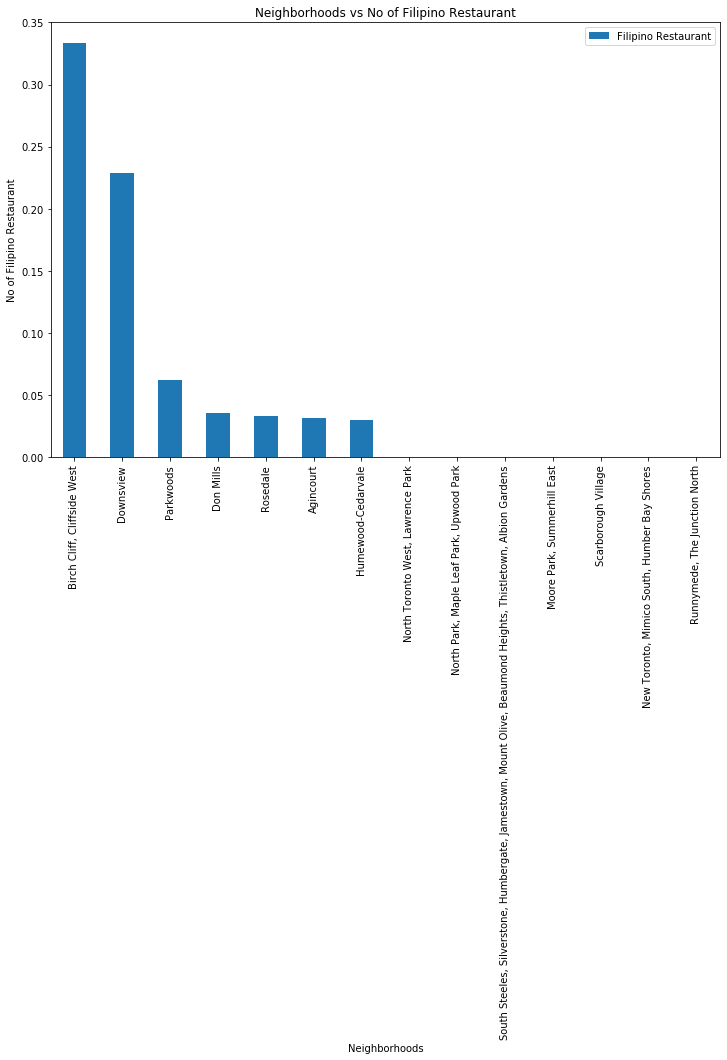

In [25]:
graph = pd.DataFrame(toronto_merged.groupby('Neighborhood')['Filipino Restaurant'].sum())
graph = graph.sort_values(by ='Filipino Restaurant', ascending=False)
graph.iloc[:14].plot(kind='bar', figsize=(12,8))
plt.xlabel("Neighborhoods")
plt.ylabel("No of Filipino Restaurant")
plt.title("Neighborhoods vs No of Filipino Restaurant")
plt.show()

According to the graph , It can be perceived that the highest number of Filipino Restaurants reside in the neighborhoods of Birch Cliff,Cliffside west, Parkwoods , Downsview, Humewoods-Cedarvale , Don Mills , Rosedale and Agincourt.

## In this section we will extract the ethinicity data of Toronto found on Wikipedia and try to filter it to include only the Filipino popoulation in Toronto and each Neigborhood , this , along with the numbers of restaurants in neighborhoods, will help us have a better idea on where will be a good location for a new Filipino restaurant

##### The Wikipedea package was imported earlier in this book

In [26]:
#TORONTO & EAST YORK population distribution by ethnicity 
TEY_population_df = pd.read_html(html, header = 0)[12]
TEY_population_df = TEY_population_df.rename(columns={'%':'Ethnic Origin 1 in %', 
                                                      '%.1':'Ethnic Origin 2 in %',
                                                     '%.2':'Ethnic Origin 3 in %',
                                                     '%.3':'Ethnic Origin 4 in %',
                                                     '%.4':'Ethnic Origin 5 in %',
                                                     '%.5':'Ethnic Origin 6 in %',
                                                     '%.6':'Ethnic Origin 7 in %',
                                                     '%.7':'Ethnic Origin 8 in %',
                                                     '%.8':'Ethnic Origin 9 in %'})
TEY_population_df

,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %,Ethnic Origin #9,Ethnic Origin 9 in %
0,Spadina-Fort York,114315,English,16.4,Chinese,16.0,Irish,14.6,Canadian,14.0,Scottish,13.2,French,7.70,German,7.6,NaN,NaN,NaN,NaN
1,Beaches-East York,108435,English,24.2,Irish,19.9,Canadian,19.7,Scottish,18.9,French,8.7,German,8.40,NaN,NaN,NaN,NaN,NaN,NaN
2,Davenport,107395,Portuguese,22.7,English,13.6,Canadian,12.8,Irish,11.5,Italian,11.1,Scottish,11.00,NaN,NaN,NaN,NaN,NaN,NaN
3,Parkdale-High Park,106445,English,22.3,Irish,20.0,Scottish,18.7,Canadian,16.1,German,9.8,French,8.88,Polish,8.5,NaN,NaN,NaN,NaN
4,Toronto-Danforth,105395,English,22.9,Irish,19.5,Scottish,18.7,Canadian,18.4,Chinese,13.8,French,8.86,German,8.8,Greek,7.3,NaN,NaN
5,Toronto-St. Paul's,104940,English,18.5,Canadian,16.1,Irish,15.2,Scottish,14.8,Polish,10.3,German,7.90,Russian,7.7,Italian,7.3,French,7.2
6,University-Rosedale,100520,English,20.6,Irish,16.6,Scottish,16.3,Canadian,15.2,Chinese,14.7,German,8.70,French,7.7,Italian,7.4,NaN,NaN
7,Toronto Centre,99590,English,15.7,Canadian,13.7,Irish,13.4,Scottish,12.6,Chinese,12.5,French,7.20,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
#NORTH YORK population distribution by ethnicity 
North_population_df = pd.read_html(html, header = 0)[13]
North_population_df = North_population_df.rename(columns={'%':'Ethnic Origin 1 in %', 
                                                      '%.1':'Ethnic Origin 2 in %',
                                                     '%.2':'Ethnic Origin 3 in %',
                                                     '%.3':'Ethnic Origin 4 in %',
                                                     '%.4':'Ethnic Origin 5 in %',
                                                     '%.5':'Ethnic Origin 6 in %',
                                                     '%.6':'Ethnic Origin 7 in %',
                                                     '%.7':'Ethnic Origin 8 in %'})
North_population_df

,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %
0,Willowdale,117405,Chinese,25.9,Iranian,12.1,Korean,10.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Eglinton-Lawrence,112925,Canadian,14.7,English,12.6,Polish,12.0,Filipino,11.0,Scottish,9.7,Italian,9.5,Irish,9.2,Russian,8.4
2,Don Valley North,109060,Chinese,32.4,East Indian,7.3,Iranian,7.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Humber River-Black Creek,107725,Italian,12.8,East Indian,9.2,Jamaican,8.5,Vietnamese,8.0,Canadian,7.4,NaN,NaN,NaN,NaN,NaN,NaN
4,York Centre,103760,Filipino,17.0,Italian,13.4,Russian,9.5,Canadian,8.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Don Valley West,101790,English,19.2,Canadian,15.1,Scottish,14.9,Irish,14.2,Chinese,11.2,NaN,NaN,NaN,NaN,NaN,NaN
6,Don Valley East,93170,East Indian,10.6,Canadian,10.4,English,10.1,Chinese,8.9,Irish,8.1,Scottish,8.0,Filipino,7.8,NaN,NaN


In [28]:
#SCARBOROUGH population distribution by ethnicity 
Scar_population_df = pd.read_html(html, header = 0)[14]
Scar_population_df = Scar_population_df.rename(columns={'%':'Ethnic Origin 1 in %', 
                                                      '%.1':'Ethnic Origin 2 in %',
                                                     '%.2':'Ethnic Origin 3 in %',
                                                     '%.3':'Ethnic Origin 4 in %',
                                                     '%.4':'Ethnic Origin 5 in %',
                                                     '%.5':'Ethnic Origin 6 in %',
                                                     '%.6':'Ethnic Origin 7 in %',
                                                     '%.7':'Ethnic Origin 8 in %'})
Scar_population_df

,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %
0,Scarborough Centre,110450,Filipino,13.1,East Indian,12.2,Canadian,11.2,Chinese,10.7,English,7.8,Sri Lankan,7.0,NaN,NaN,NaN,NaN
1,Scarborough Southwest,108295,Canadian,16.2,English,14.3,Irish,11.5,Scottish,10.9,Filipino,9.5,East Indian,8.2,Chinese,7.2,NaN,NaN
2,Scarborough-Agincourt,104225,Chinese,47.0,East Indian,7.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Scarborough-Rouge Park,101445,East Indian,16.7,Canadian,11.8,Sri Lankan,11.1,English,9.8,Filipino,9.3,Jamaican,8.4,Scottish,7.2,Irish,7.0
4,Scarborough-Guildwood,101115,East Indian,18.0,Canadian,11.6,English,9.7,Filipino,8.5,Sri Lankan,7.8,Chinese,7.1,Scottish,7.0,NaN,NaN
5,Scarborough North,97610,Chinese,46.6,East Indian,11.8,Sri Lankan,9.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
#ETOBICOKE & YORK population distribution by ethnicity 
ETY_population_df = pd.read_html(html, header = 0)[15]
ETY_population_df = ETY_population_df.rename(columns={'%':'Ethnic Origin 1 in %', 
                                                      '%.1':'Ethnic Origin 2 in %',
                                                     '%.2':'Ethnic Origin 3 in %',
                                                     '%.3':'Ethnic Origin 4 in %',
                                                     '%.4':'Ethnic Origin 5 in %',
                                                     '%.5':'Ethnic Origin 6 in %',
                                                     '%.6':'Ethnic Origin 7 in %',
                                                     '%.7':'Ethnic Origin 8 in %'})
ETY_population_df

,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %
0,Etobicoke-Lakeshore,127520,English,17.1,Canadian,15.9,Irish,14.4,Scottish,13.5,Polish,9.2,Italian,9.1,Ukrainian,7.6,German,7.1
1,Etobicoke North,116960,East Indian,22.2,Canadian,7.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Etobicoke Centre,116055,Italian,15.1,English,14.3,Canadian,12.1,Irish,10.8,Scottish,10.4,Ukrainian,8.1,Polish,7.4,NaN,NaN
3,York South-Weston,115130,Portuguese,14.5,Italian,12.8,Canadian,8.7,Jamaican,8.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# here we merge all the previous tables together 
ET = ETY_population_df.append(TEY_population_df,sort=True).reset_index()
ET.drop('index',axis=1,inplace=True)
SN = North_population_df.append(Scar_population_df,sort=True).reset_index()
SN.drop('index',axis=1,inplace=True)
pop_ethnic_df = SN.append(ET,sort=True).reset_index()
pop_ethnic_df.drop('index',axis=1,inplace=True)
pop_ethnic_df = pop_ethnic_df[['Riding', 'Population','Ethnic Origin #1', 'Ethnic Origin 1 in %','Ethnic Origin #2', 'Ethnic Origin 2 in %',
                               'Ethnic Origin #3','Ethnic Origin 3 in %','Ethnic Origin #4', 'Ethnic Origin 4 in %','Ethnic Origin #5','Ethnic Origin 5 in %', 
                               'Ethnic Origin #6','Ethnic Origin 6 in %','Ethnic Origin #7', 'Ethnic Origin 7 in %','Ethnic Origin #8', 'Ethnic Origin 8 in %',
                               'Ethnic Origin #9','Ethnic Origin 9 in %',
                              ]]
pop_ethnic_df

,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %,Ethnic Origin #9,Ethnic Origin 9 in %
0,Willowdale,117405,Chinese,25.9,Iranian,12.1,Korean,10.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Eglinton-Lawrence,112925,Canadian,14.7,English,12.6,Polish,12.0,Filipino,11.0,Scottish,9.7,Italian,9.50,Irish,9.2,Russian,8.4,NaN,NaN
2,Don Valley North,109060,Chinese,32.4,East Indian,7.3,Iranian,7.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Humber River-Black Creek,107725,Italian,12.8,East Indian,9.2,Jamaican,8.5,Vietnamese,8.0,Canadian,7.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,York Centre,103760,Filipino,17.0,Italian,13.4,Russian,9.5,Canadian,8.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Don Valley West,101790,English,19.2,Canadian,15.1,Scottish,14.9,Irish,14.2,Chinese,11.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Don Valley East,93170,East Indian,10.6,Canadian,10.4,English,10.1,Chinese,8.9,Irish,8.1,Scottish,8.00,Filipino,7.8,NaN,NaN,NaN,NaN
7,Scarborough Centre,110450,Filipino,13.1,East Indian,12.2,Canadian,11.2,Chinese,10.7,English,7.8,Sri Lankan,7.00,NaN,NaN,NaN,NaN,NaN,NaN
8,Scarborough Southwest,108295,Canadian,16.2,English,14.3,Irish,11.5,Scottish,10.9,Filipino,9.5,East Indian,8.20,Chinese,7.2,NaN,NaN,NaN,NaN
9,Scarborough-Agincourt,104225,Chinese,47.0,East Indian,7.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
#Filtering the riding with the Filipino population
temp = pop_ethnic_df.loc[(pop_ethnic_df['Ethnic Origin #1'] == 'Filipino')| 
                                      (pop_ethnic_df['Ethnic Origin #2'] == 'Filipino')|
                                      (pop_ethnic_df['Ethnic Origin #3'] == 'Filipino')|
                                      (pop_ethnic_df['Ethnic Origin #4'] == 'Filipino')|
                                      (pop_ethnic_df['Ethnic Origin #5'] == 'Filipino')|
                                      (pop_ethnic_df['Ethnic Origin #6'] == 'Filipino')|
                                      (pop_ethnic_df['Ethnic Origin #7'] == 'Filipino')|
                                      (pop_ethnic_df['Ethnic Origin #8'] == 'Filipino')|
                                      (pop_ethnic_df['Ethnic Origin #9'] == 'Filipino')]
pop_filipino_df = pd.DataFrame(temp).reset_index()
pop_filipino_df.drop('index',axis=1,inplace=True)

pop_filipino_df

,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %,Ethnic Origin #9,Ethnic Origin 9 in %
0,Eglinton-Lawrence,112925,Canadian,14.7,English,12.6,Polish,12.0,Filipino,11.0,Scottish,9.7,Italian,9.5,Irish,9.2,Russian,8.4,NaN,NaN
1,York Centre,103760,Filipino,17.0,Italian,13.4,Russian,9.5,Canadian,8.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Don Valley East,93170,East Indian,10.6,Canadian,10.4,English,10.1,Chinese,8.9,Irish,8.1,Scottish,8.0,Filipino,7.8,NaN,NaN,NaN,NaN
3,Scarborough Centre,110450,Filipino,13.1,East Indian,12.2,Canadian,11.2,Chinese,10.7,English,7.8,Sri Lankan,7.0,NaN,NaN,NaN,NaN,NaN,NaN
4,Scarborough Southwest,108295,Canadian,16.2,English,14.3,Irish,11.5,Scottish,10.9,Filipino,9.5,East Indian,8.2,Chinese,7.2,NaN,NaN,NaN,NaN
5,Scarborough-Rouge Park,101445,East Indian,16.7,Canadian,11.8,Sri Lankan,11.1,English,9.8,Filipino,9.3,Jamaican,8.4,Scottish,7.2,Irish,7.0,NaN,NaN
6,Scarborough-Guildwood,101115,East Indian,18.0,Canadian,11.6,English,9.7,Filipino,8.5,Sri Lankan,7.8,Chinese,7.1,Scottish,7.0,NaN,NaN,NaN,NaN


In [32]:
#retaining only filipino ethnic percentage & the neighborhood name 
columns_list = pop_filipino_df.columns.to_list()
pop_filipino_DF_with_percent = pd.DataFrame()
#removing Riding & Population from the column names list
del columns_list[0]
del columns_list[0]


for i in range(0,pop_filipino_df.shape[0]):
    for j in columns_list:
        print(j)
        if pop_filipino_df.at[i, j] == 'Filipino':
            k = columns_list.index(j) + 1
            percent_col = columns_list[k]
            pop_filipino_DF_with_percent = pop_filipino_DF_with_percent.append({'Riding':pop_filipino_df.at[i, 'Riding'], 'Population':pop_filipino_df.at[i, 'Population']
                                                                           , 'Ethnicity': pop_filipino_df.at[i, j], 'Percentage': pop_filipino_df.at[i, percent_col]},ignore_index=True)

pop_filipino_DF_with_percent

Ethnic Origin #1
Ethnic Origin 1 in %
Ethnic Origin #2
Ethnic Origin 2 in %
Ethnic Origin #3
Ethnic Origin 3 in %
Ethnic Origin #4
Ethnic Origin 4 in %
Ethnic Origin #5
Ethnic Origin 5 in %
Ethnic Origin #6
Ethnic Origin 6 in %
Ethnic Origin #7
Ethnic Origin 7 in %
Ethnic Origin #8
Ethnic Origin 8 in %
Ethnic Origin #9
Ethnic Origin 9 in %
Ethnic Origin #1
Ethnic Origin 1 in %
Ethnic Origin #2
Ethnic Origin 2 in %
Ethnic Origin #3
Ethnic Origin 3 in %
Ethnic Origin #4
Ethnic Origin 4 in %
Ethnic Origin #5
Ethnic Origin 5 in %
Ethnic Origin #6
Ethnic Origin 6 in %
Ethnic Origin #7
Ethnic Origin 7 in %
Ethnic Origin #8
Ethnic Origin 8 in %
Ethnic Origin #9
Ethnic Origin 9 in %
Ethnic Origin #1
Ethnic Origin 1 in %
Ethnic Origin #2
Ethnic Origin 2 in %
Ethnic Origin #3
Ethnic Origin 3 in %
Ethnic Origin #4
Ethnic Origin 4 in %
Ethnic Origin #5
Ethnic Origin 5 in %
Ethnic Origin #6
Ethnic Origin 6 in %
Ethnic Origin #7
Ethnic Origin 7 in %
Ethnic Origin #8
Ethnic Origin 8 in %
Ethnic Origi

,Ethnicity,Percentage,Population,Riding
0,Filipino,11.0,112925.0,Eglinton-Lawrence
1,Filipino,17.0,103760.0,York Centre
2,Filipino,7.8,93170.0,Don Valley East
3,Filipino,13.1,110450.0,Scarborough Centre
4,Filipino,9.5,108295.0,Scarborough Southwest
5,Filipino,9.3,101445.0,Scarborough-Rouge Park
6,Filipino,8.5,101115.0,Scarborough-Guildwood


In [33]:
# Calculating the actual number of the Filipino population 
pop_filipino_DF_with_percent['The Filipino population'] = (pop_filipino_DF_with_percent['Percentage'] * pop_filipino_DF_with_percent['Population'])/100
pop_filipino_DF_with_percent.drop(columns={'Percentage','Population','Ethnicity'},axis=1, inplace =True)
pop_filipino_DF_with_percent.drop_duplicates(keep='first',inplace=True) 
pop_filipino_DF_with_percent

,Riding,The Filipino population
0,Eglinton-Lawrence,12421.750
1,York Centre,17639.200
2,Don Valley East,7267.260
3,Scarborough Centre,14468.950
4,Scarborough Southwest,10288.025
5,Scarborough-Rouge Park,9434.385
6,Scarborough-Guildwood,8594.775


## A bar graph showing the ridings containing the highest Filipino popoulation

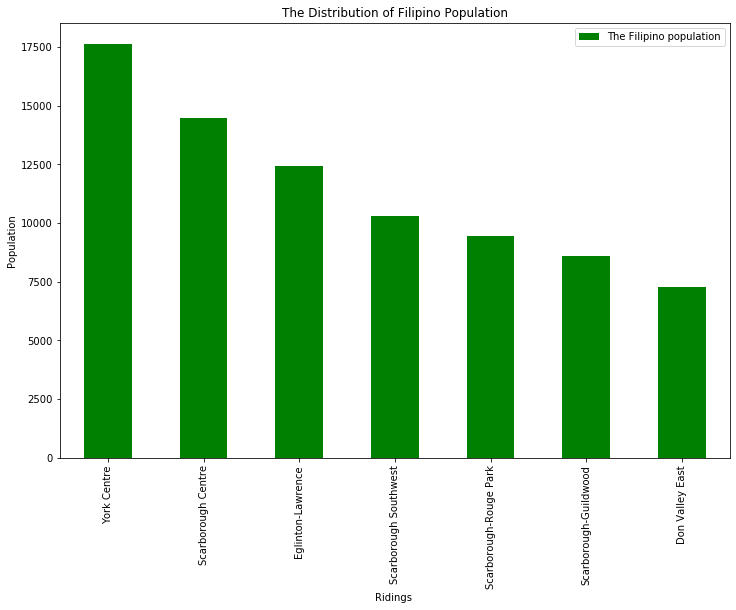

In [34]:
# Plotting each riding with the corresponding population 
bar_graph = pop_filipino_DF_with_percent.sort_values(by='The Filipino population', ascending=False)
bar_graph.plot(kind='bar',x='Riding', y='The Filipino population',figsize=(12,8), color='green')
plt.title("The Distribution of Filipino Population")
plt.xlabel("Ridings ")
plt.ylabel("Population")
plt.show()

### next we will split the ridings into neighborhoods

In [35]:
#changing the name to match whats in Wikipeadia otherwise it wont be recongnized
riding_list = pop_filipino_DF_with_percent['Riding'].to_list()
riding_list[riding_list.index('Scarborough Centre')] = 'Scarborough Centre (electoral district)'

riding_list

['Eglinton-Lawrence',
 'York Centre',
 'Don Valley East',
 'Scarborough Centre (electoral district)',
 'Scarborough Southwest',
 'Scarborough-Rouge Park',
 'Scarborough-Guildwood']

In [36]:
del(riding_list[0])

In [37]:
import wikipedia

Riding_neighborhood_df = pd.DataFrame()
 
for item in riding_list:
    section = wikipedia.WikipediaPage(item).section('Geography')
    start = section.index('neighbourhoods of')+17
    stop = section.index('.',start)
    Riding_neighborhood_df = Riding_neighborhood_df.append({'Riding':item, 'Neighborhoods':section[start:stop]},ignore_index=True)
    

Riding_neighborhood_df = Riding_neighborhood_df[['Riding','Neighborhoods']]
Riding_neighborhood_df

,Riding,Neighborhoods
0,York Centre,"Westminster–Branson, Bathurst Manor, Wilson H..."
1,Don Valley East,"Flemingdon Park, Don Mills, Graydon Hall, Par..."
2,Scarborough Centre (electoral district),Scarborough City Centre (west of McCowan Road...
3,Scarborough Southwest,"Birch Cliff, Oakridge, Cliffside, Kennedy Par..."
4,Scarborough-Rouge Park,"Morningside Heights, Rouge, Port Union, West ..."
5,Scarborough-Guildwood,"Guildwood, West Hill (west of Morningside Ave..."


In [38]:
# Pass the row elements as key value pairs to append() function 
#adding the Eglinton_lawrence since its shown differelnty on Wikipeadia 
new = Riding_neighborhood_df.append({'Riding' : 'Eglinton-Lawrence' , 'Neighborhoods' : ' Bedford Park, Lawrence Manor, Lawrence Heights, the southwestern part of York Mills and the western part of Lawrence Park.'} , ignore_index=True)
new

,Riding,Neighborhoods
0,York Centre,"Westminster–Branson, Bathurst Manor, Wilson H..."
1,Don Valley East,"Flemingdon Park, Don Mills, Graydon Hall, Par..."
2,Scarborough Centre (electoral district),Scarborough City Centre (west of McCowan Road...
3,Scarborough Southwest,"Birch Cliff, Oakridge, Cliffside, Kennedy Par..."
4,Scarborough-Rouge Park,"Morningside Heights, Rouge, Port Union, West ..."
5,Scarborough-Guildwood,"Guildwood, West Hill (west of Morningside Ave..."
6,Eglinton-Lawrence,"Bedford Park, Lawrence Manor, Lawrence Height..."


### Merging the two tables so now we have the population per Neighborhood

In [39]:
Neigh_pop = pd.merge(pop_filipino_DF_with_percent, new, on='Riding')

Neigh_pop.drop(columns=['Riding'],inplace =True)
Neigh_pop

,The Filipino population,Neighborhoods
0,12421.750,"Bedford Park, Lawrence Manor, Lawrence Height..."
1,17639.200,"Westminster–Branson, Bathurst Manor, Wilson H..."
2,7267.260,"Flemingdon Park, Don Mills, Graydon Hall, Par..."
3,10288.025,"Birch Cliff, Oakridge, Cliffside, Kennedy Par..."
4,9434.385,"Morningside Heights, Rouge, Port Union, West ..."
5,8594.775,"Guildwood, West Hill (west of Morningside Ave..."


In [40]:
#splitting the neighborhoods to be in separate rows

Neigh_pop['split_neighborhoods'] = Neigh_pop['Neighborhoods'].str.split(',') 
Neigh_pop.drop(columns=['Neighborhoods'],inplace=True,axis=1)
Neigh_pop = Neigh_pop.split_neighborhoods.apply(pd.Series).merge(Neigh_pop, left_index = True, right_index = True).drop(["split_neighborhoods"], axis = 1)\
                    .melt(id_vars = ['The Filipino population'], value_name = "Neighborhood").drop("variable", axis = 1).dropna()

Neigh_pop.reset_index()
Neigh_pop

,The Filipino population,Neighborhood
0,12421.750,Bedford Park
1,17639.200,Westminster–Branson
2,7267.260,Flemingdon Park
3,10288.025,Birch Cliff
4,9434.385,Morningside Heights
5,8594.775,Guildwood
6,12421.750,Lawrence Manor
7,17639.200,Bathurst Manor
8,7267.260,Don Mills
9,10288.025,Oakridge


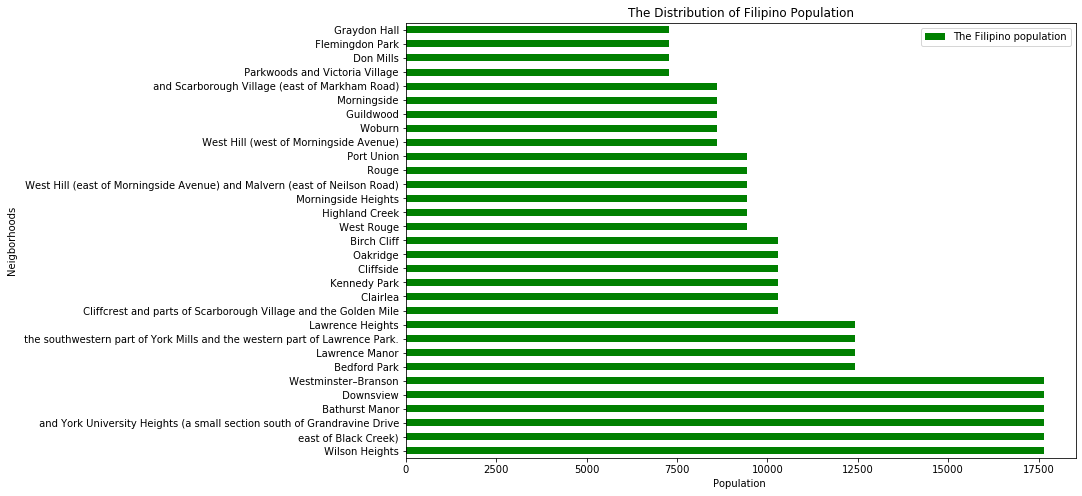

In [41]:
# Plotting each riding with the corresponding population 
bar_graph = Neigh_pop.sort_values(by='The Filipino population', ascending=False)
bar_graph.plot(kind='barh',x='Neighborhood', y='The Filipino population',figsize=(12,8), color='green')
plt.title("The Distribution of Filipino Population")
plt.xlabel("Population ")
plt.ylabel("Neigborhoods")
plt.show()

The graph shows that the Neighborhoods with the highest population of the Filipino community in descending order are Wilson Heights , East of Black Creek , York University Heights,  Bathurst Manor ,Downsview , Westminster-Branson , Bedford Park , Lawrence Manor, Birch Cliff , Rough , Morningside Heights , Guildwood , Flemingdon Park and Dons Mills .

Now we link the Filipino restaurants found earlier with the Filipino Ethnic neighborhoods.

In [42]:
#splitting the neighborhoods in the eailer table , any words separated by commas will be split into two rows
toronto_part['split_neighborhoods'] = toronto_part['Neighborhood'].str.split(',') 
toronto_part.drop(columns=['Neighborhood'],inplace=True,axis=1)
toronto_part = toronto_part.split_neighborhoods.apply(pd.Series).merge(toronto_part, left_index = True, right_index = True).drop(["split_neighborhoods"], axis = 1)\
                    .melt(id_vars = ['Filipino Restaurant'], value_name = "Neighborhood").drop("variable", axis = 1).dropna()

toronto_part.reset_index()
toronto_part

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Filipino Restaurant,Neighborhood
0,0.031250,Agincourt
1,0.000000,Alderwood
2,0.000000,Bathurst Manor
3,0.000000,Bayview Village
4,0.000000,Bedford Park
5,0.000000,Berczy Park
6,0.333333,Birch Cliff
7,0.000000,Brockton
8,0.000000,Business reply mail Processing Centre
9,0.000000,CN Tower


In [43]:
# merge the 2 previous tables to include the Filipino population and Restaurants as per Neighborhoods
pop_merged_restaurant_percent = pd.merge(Neigh_pop, toronto_part, on='Neighborhood')
pop_merged_restaurant_percent.head()

,The Filipino population,Neighborhood,Filipino Restaurant
0,10288.025,Oakridge,0.0
1,9434.385,Rouge,0.0
2,12421.750,Lawrence Heights,0.0
3,17639.200,Wilson Heights,0.0
4,9434.385,Port Union,0.0


In [44]:
pop_merged_restaurant_percent

,The Filipino population,Neighborhood,Filipino Restaurant
0,10288.025,Oakridge,0.0
1,9434.385,Rouge,0.0
2,12421.750,Lawrence Heights,0.0
3,17639.200,Wilson Heights,0.0
4,9434.385,Port Union,0.0
5,8594.775,Morningside,0.0
6,10288.025,Clairlea,0.0
7,9434.385,Highland Creek,0.0


Unfortunately, the above results seem inconclusive where there is no clear relationship between the population and restaurants that can be observed. This could be due to the outdated data of the Filipino population or probably some inaccuracies in the Foursquare databases where Filipino restaurants aren’t clearly labeled.

## now we will use K-mean cluster to group the neighborhoods and find similiarties between them

### First we will use the elbow method to find the optimuim K

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return_n_iter=True)


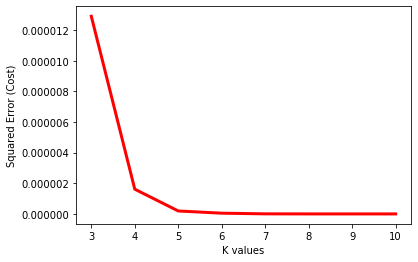

In [45]:
from sklearn.cluster import KMeans

toronto_part_clustering = toronto_part.drop('Neighborhood', 1)

#Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)

error_cost = []

for i in range(3,11):
    KM = KMeans(n_clusters = i, max_iter = 100)
    try:
        KM.fit(toronto_part_clustering)
    except ValueError:
        print("error on line",i)
    
    
    
    
    #calculate squared error for the clustered points
    error_cost.append(KM.inertia_/100)

#plot the K values aganist the squared error cost
plt.plot(range(3,11), error_cost, color='r', linewidth='3')
plt.xlabel('K values')
plt.ylabel('Squared Error (Cost)')
plt.grid(color='white', linestyle='-', linewidth=2)
plt.show()

### According to the graph , its K=6

In [46]:
# set number of clusters
kclusters = 6

Toronto_grouped_clustering = toronto_part.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=2).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int32)

In [47]:
#sorted_neighborhoods_venues.drop(['Cluster Labels'],axis=1,inplace=True)
toronto_part.insert(0, 'Cluster Labels', kmeans.labels_)
toronto_merged = hood_merged
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(toronto_part.set_index('Neighborhood'), on='Neighborhood')
toronto_merged.dropna(subset=["Cluster Labels"], axis=0, inplace=True)
toronto_merged.reset_index(drop=True, inplace=True)
toronto_merged['Cluster Labels'].astype(int)
toronto_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Filipino Restaurant
0,M1G,Scarborough,Woburn,43.770992,-79.216917,0.0,0.00000
1,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0.0,0.00000
2,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,0.0,0.00000
3,M1S,Scarborough,Agincourt,43.794200,-79.262029,2.0,0.03125
4,M2H,North York,Hillcrest Village,43.803762,-79.363452,0.0,0.00000


## Visualizing the clusters

In [48]:
import matplotlib.cm as cm
import matplotlib.colors as colors

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11, width='90%', height='70%')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters

## Examining the clusters

In [49]:
#Cluster 0
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Filipino Restaurant
0,M1G,Scarborough,Woburn,43.770992,-79.216917,0.0,0.0
1,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0.0,0.0
2,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,0.0,0.0
4,M2H,North York,Hillcrest Village,43.803762,-79.363452,0.0,0.0
5,M2K,North York,Bayview Village,43.786947,-79.385975,0.0,0.0
6,M2P,North York,York Mills West,43.752758,-79.400049,0.0,0.0
14,M4A,North York,Victoria Village,43.725882,-79.315572,0.0,0.0
15,M4C,East York,Woodbine Heights,43.695344,-79.318389,0.0,0.0
16,M4E,East Toronto,The Beaches,43.676357,-79.293031,0.0,0.0
17,M4G,East York,Leaside,43.709060,-79.363452,0.0,0.0


Next we have cluster 0 , It has the neighborhoods with no amount of Filipino Restaurants, Its shown in red color on the map 

In [50]:
#Cluster 1
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Filipino Restaurant


Clusters 1 doesn’t contain any data points or neighborhoods  (reflected in the map as well) , hence we won’t consider it in any decision making .

In [51]:
#Cluster 2
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Filipino Restaurant
3,M1S,Scarborough,Agincourt,43.794200,-79.262029,2.0,0.031250
23,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529,2.0,0.033333
32,M6C,York,Humewood-Cedarvale,43.693781,-79.428191,2.0,0.030303


Cluster 2 contains the neighborhoods with a wide range of distributed  Filipino restaurants, Shown in blue.

In [52]:
#Cluster 3
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Filipino Restaurant
7,M3A,North York,Parkwoods,43.753259,-79.329656,3.0,0.0625


Cluster 3 contains the neighborhoods that are highly occupied with Filipino restaurants, Shown in turquoise.

In [54]:
#Cluster 4
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Filipino Restaurant
8,M3B,North York,Don Mills,43.745906,-79.352188,4.0,0.017857
9,M3C,North York,Don Mills,43.725900,-79.340923,4.0,0.017857


Cluster 4 contains the neighborhoods that are relatively the least occupied with Filipino restaurants, Shown in olive green .

In [55]:
#Cluster 5
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Filipino Restaurant
10,M3K,North York,Downsview,43.737473,-79.464763,5.0,0.057143
11,M3L,North York,Downsview,43.739015,-79.506944,5.0,0.057143
12,M3M,North York,Downsview,43.728496,-79.495697,5.0,0.057143
13,M3N,North York,Downsview,43.761631,-79.520999,5.0,0.057143


Cluster 5 contains the neighborhoods that are relatively medially occupied Filipino restaurants, Shown in orange.